In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import numpy as np
from scipy.optimize import curve_fit


the goal of this document is to fit a sin wave to data which can then hopefully be used to calculate g

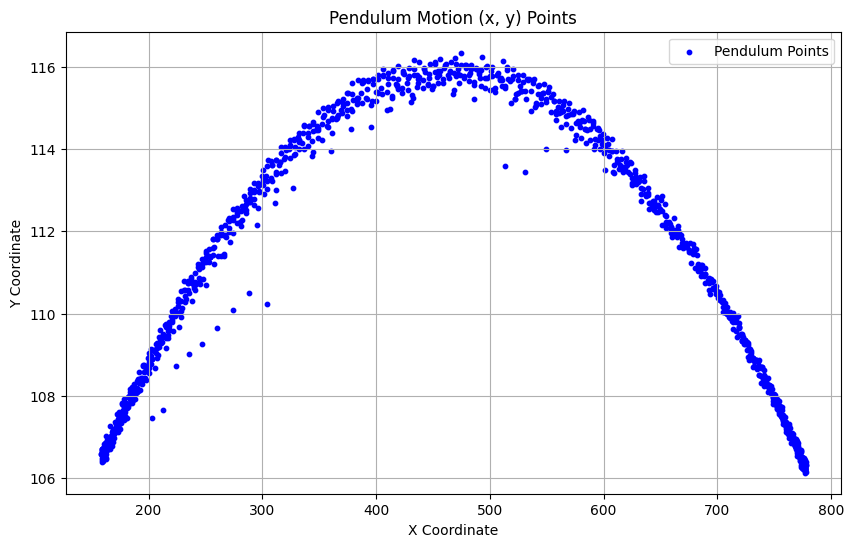

In [29]:
# Load the CSV data containing the results
csv_file_path = '../CSV Files/coordinates_Feb25Rusty_run3.csv'
data = pd.read_csv(csv_file_path)

# Extract x (x-coordinate) and y (y-coordinate)
x = data['x'].values
y = data['y'].values
time = data['Time'].values

indices = y > 106
#Extract corresponding time values
t_values = time[indices]

y = y[indices]
x=x[indices]
time = time[indices]

# Plot the (x, y) points
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='b', s=10, label='Pendulum Points')

# Optionally, you can connect the points with lines to visualize the trajectory
# plt.plot(cx, cy, color='g', linewidth=1, linestyle='-', alpha=0.6)

# Add labels and title
plt.title('Pendulum Motion (x, y) Points')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Add a grid and show the plot
plt.grid(True)
plt.legend()
plt.show()


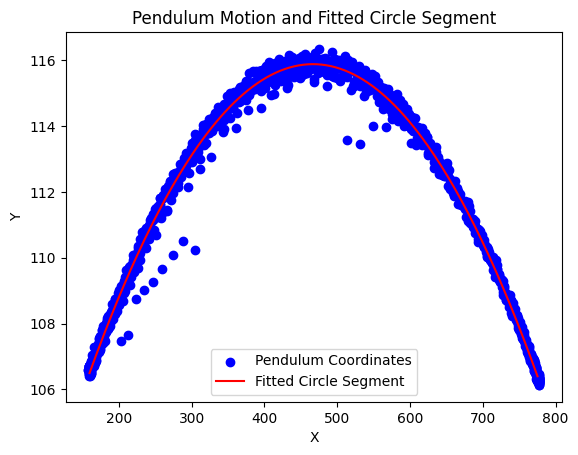

Estimated Origin (Center of Circle): (466.7154562467576, -4909.731225865442)


In [30]:
def circle_residuals(params, x, y):
    cx, cy, r = params
    return (x - cx)**2 + (y - cy)**2 - r**2

# Initial guess for the center (cx, cy) and radius (r)
initial_guess = [np.mean(x), np.mean(y), np.std(x)]

# Use least squares to fit the circle
result = least_squares(circle_residuals, initial_guess, args=(x, y))

# Extract the center (cx, cy) and radius (r) of the fitted circle
cx, cy, r = result.x

# Generate circle points but only in the range of x and y values
theta = np.linspace(0, 2 * np.pi, 10000)
circle_x = cx + r * np.cos(theta)
circle_y = cy + r * np.sin(theta)

# **Filter the circle points to only keep those near the data points**
mask = (circle_x >= min(x)) & (circle_x <= max(x)) & (circle_y >= min(y)) & (circle_y <= max(y))
circle_x_filtered = circle_x[mask]
circle_y_filtered = circle_y[mask]

# Plot the points and the fitted partial circle
plt.scatter(x, y, label='Pendulum Coordinates', color='blue')
plt.plot(circle_x_filtered, circle_y_filtered, label='Fitted Circle Segment', color='red')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Pendulum Motion and Fitted Circle Segment')
plt.legend()
plt.show()

# Output the estimated origin (cx, cy)
print(f"Estimated Origin (Center of Circle): ({cx}, {cy})")

In [31]:

# Compute angles in radians
theta = np.arctan2(y - cy, x - cx)


# Normalize by subtracting the mean angle
theta_mid = np.mean(theta)
theta_normalized = theta - theta_mid

# Ensure angles remain within [-π, π] range
theta_normalized = np.arctan2(np.sin(theta_normalized), np.cos(theta_normalized))

# # Plot angle vs. time
# plt.figure(figsize=(10, 5))
# plt.plot(time, theta_normalized, label="Pendulum Angle (radians)", color='b')
# plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Midline
# plt.xlabel("Time (s)")
# plt.ylabel("Angle (radians)")
# plt.title("Pendulum Angle Over Time")
# plt.legend()
# plt.grid(True)
# plt.show()


In [32]:
# Create a DataFrame with time and normalized angle
angle_data = pd.DataFrame({
    "time": time,
    "angle": theta_normalized
})

# Save to a CSV file
angle_data.to_csv("pendulum_angles.csv", index=False)

In [35]:
L = .787

C:\Users\z4ckg\AppData\Local\Temp\ipykernel_30092\3053995699.py:31: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)


Fitted parameters: A = 0.061, ω = 3.506, φ = 2.328, Offset = -0.000
Estimated Period: 1.792 s


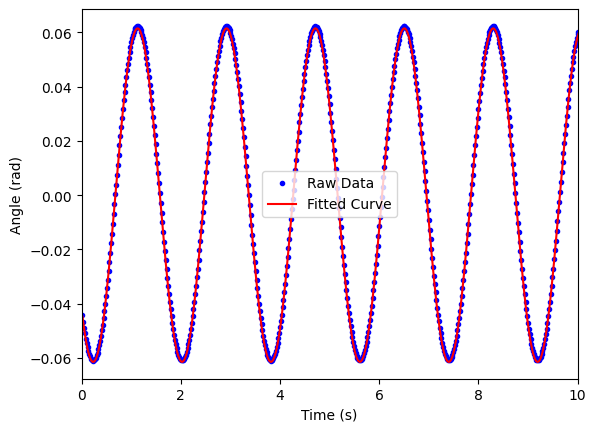

In [36]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

def fit_pendulum(tt, yy):
    '''Fit a sine function to the input time sequence, and return fitting parameters for pendulum motion.'''
    tt = np.array(tt)
    yy = np.array(yy)
    
    # Use FFT to estimate the frequency (this gives us a good guess for omega)
    ff = np.fft.fftfreq(len(tt), tt[1] - tt[0])   # Assume uniform time spacing
    Fyy = np.abs(np.fft.fft(yy))
    guess_freq = np.abs(ff[np.argmax(Fyy[1:]) + 1])  # Ignore the zero frequency (offset) peak
    
    # Estimate amplitude and offset
    guess_amp = (np.max(yy) - np.min(yy)) / 2
    guess_offset = np.mean(yy)
    
    # Guess for omega (angular frequency)
    guess_omega = 2 * np.pi * guess_freq
    guess_phi = 0  # Initial guess for phase (can be adjusted based on data)
    
    # Initial guess vector
    guess = np.array([guess_amp, guess_omega, guess_phi, guess_offset])

    # Sine function to fit (pendulum's motion follows a cosine-like pattern)
    def sinfunc(t, A, w, p, c):
        return A * np.cos(w * t + p) + c

    # Perform curve fitting
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)

    # Extract fitted parameters
    A, w, p, c = popt
    
    # Calculate frequency and period
    f = w / (2 * np.pi)
    period = 1 / f
    
    # Return the fit parameters and the fitted function
    fitfunc = lambda t: A * np.cos(w * t + p) + c
    return {
        "amp": A, 
        "omega": w, 
        "phase": p, 
        "offset": c, 
        "freq": f, 
        "period": period, 
        "fitfunc": fitfunc,
        "maxcov": np.max(pcov), 
        "rawres": (guess, popt, pcov)
    }


# Fit the data
fit_results = fit_pendulum(time, theta_normalized)

# Extract fitted parameters
A_fit = fit_results['amp']
omega_fit = fit_results['omega']
phi_fit = fit_results['phase']
offset_fit = fit_results['offset']
period_fit = fit_results['period']

# Print the results
print(f"Fitted parameters: A = {A_fit:.3f}, ω = {omega_fit:.3f}, φ = {phi_fit:.3f}, Offset = {offset_fit:.3f}")
print(f"Estimated Period: {period_fit:.3f} s")

# Plot the raw data and the fitted curve
plt.plot(time, theta_normalized, 'b.', label="Raw Data")  # Blue dots for raw data
plt.plot(time, fit_results["fitfunc"](time), 'r-', label="Fitted Curve")  # Red line for fit
plt.xlim([0,10])
plt.xlabel("Time (s)")
plt.ylabel("Angle (rad)")
plt.legend()
plt.show()


In [37]:
# Create ten time blocks
# Assuming 'time' is the original time array

n = 4

# Create 50 blocks
time_blocks = [time[int(i * len(time) / n):int((i + 1) * len(time) / n)] for i in range(n)]

# Now, time_blocks contains 50 blocks, but we will only use the first 10 for analysis
#time1 = time_blocks[0]
#time2 = time_blocks[1]
#time3 = time_blocks[2]
#time4 = time_blocks[3]
#time5 = time_blocks[4]
#time6 = time_blocks[5]
#time7 = time_blocks[6]
#time8 = time_blocks[7]
#time9 = time_blocks[8]
#time10 = time_blocks[9]

time_super = time_blocks


theta_blocks = [theta[int(i * len(theta) / n):int((i + 1) * len(theta) / n)] for i in range(n)]
#theta1 = theta_blocks[0]
#theta2 = theta_blocks[1]
#theta3 = theta_blocks[2]
#theta4 = theta_blocks[3]
#theta5 = theta_blocks[4]
#theta6 = theta_blocks[5]
#theta7 = theta_blocks[6]
#theta8 = theta_blocks[7]
#theta9 = theta_blocks[8]
#theta10 = theta_blocks[9]
theta_super = theta_blocks


In [39]:
# Initialize arrays to store analysis results for each time block
amp_results = np.zeros(n)
omega_results = np.zeros(n)
phase_results = np.zeros(n)
offset_results = np.zeros(n)
freq_results = np.zeros(n)
period_results = np.zeros(n)
maxcov_results = np.zeros(n)
L = .787
# Loop over the first 10 time datasets
for i in range(n):
    # Extract the fit results for the i-th dataset (e.g., time1, time2, etc.)
    fit_results = fit_pendulum(time_blocks[i], theta_super[i])
    
    # Extract individual parameters from the fit result dictionary
    amp_results[i] = fit_results["amp"]
    omega_results[i] = fit_results["omega"]
    phase_results[i] = fit_results["phase"]
    offset_results[i] = fit_results["offset"]
    freq_results[i] = fit_results["freq"]
    period_results[i] = fit_results["period"]
    maxcov_results[i] = fit_results["maxcov"]



Computed gravity (g) for Dataset 4: 9.6711 m/s^2
 The frequency is 1.792285640617727
Computed gravity (g) for Dataset 1: 9.6721 m/s^2
 The frequency is 1.7921223366766368
Computed gravity (g) for Dataset 3: 9.6727 m/s^2
 The frequency is 1.7922257329256697


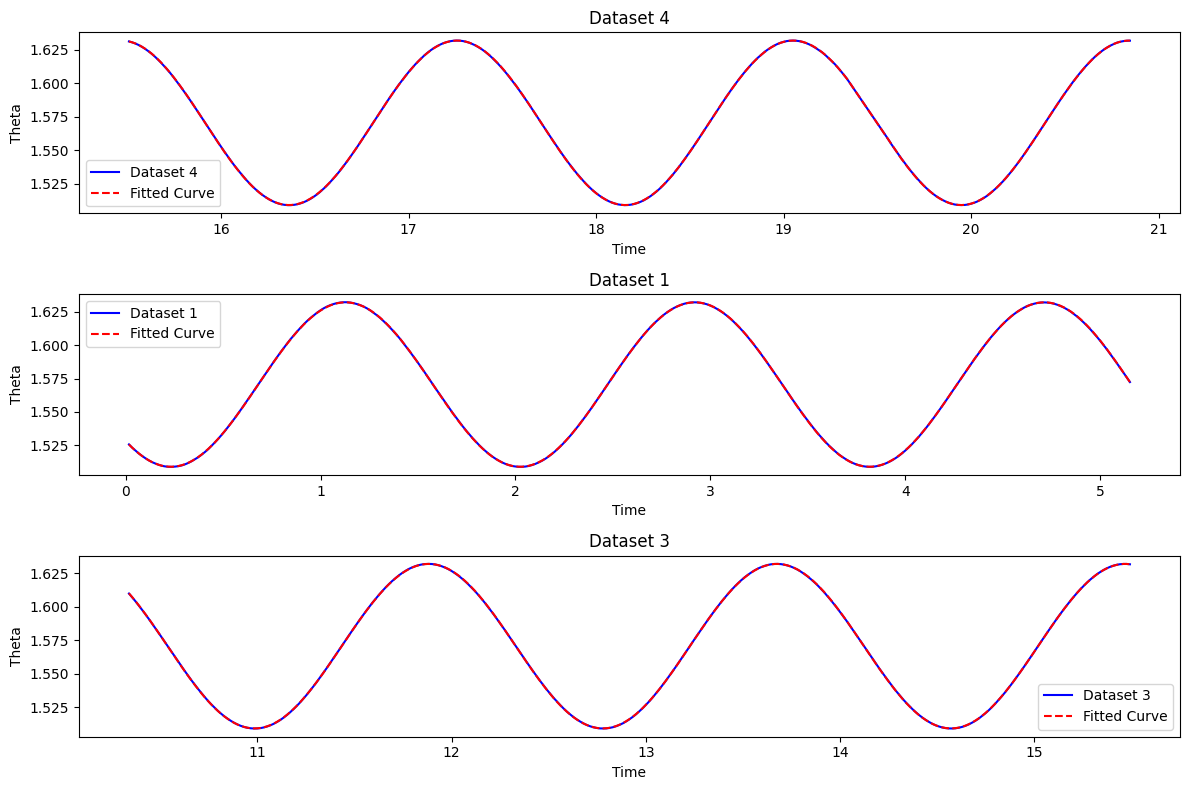

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Randomly choose 5 indices from the range 0 to 9 (for the first 10 datasets)
random_indices = np.random.choice(range(4), size=3, replace=False)

# Create subplots (2 rows, 3 columns, but will leave one empty)
fig, axs = plt.subplots(3, 1, figsize=(12, 8))

# Flatten the 2D array of axes for easier indexing
axs = axs.flatten()

# Loop through the randomly chosen datasets and plot
for i, idx in enumerate(random_indices):
    # Extract the fitting function from fit_pendulum
    fit_results = fit_pendulum(time_blocks[idx], theta_super[idx])
    fitfunc = fit_results["fitfunc"]

    omega_fit = fit_results["omega"]  # Angular frequency
    
    # Calculate gravity (g) using the formula: g = omega_fit^2 * L
    g = omega_fit**2 * L
    
    # Print the computed gravity value for this dataset
    print(f"Computed gravity (g) for Dataset {idx + 1}: {g:.4f} m/s^2")
    print(f' The frequency is {period_results[i]}')
    
    # Plot the original data (time vs theta)
    axs[i].plot(time_blocks[idx], theta_super[idx], label=f'Dataset {idx + 1}', color='blue')
    
    # Plot the fitted curve (using the fitfunc)
    axs[i].plot(time_blocks[idx], fitfunc(time_blocks[idx]), label='Fitted Curve', color='red', linestyle='--')
    
    # Set the title and labels
    axs[i].set_title(f'Dataset {idx + 1}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Theta')
    axs[i].legend()

# Adjust layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()


In [41]:
g = omega_fit**2 * L
print(g)

9.672729699003916


Fitted parameters: A = -0.025, γ = 0.000, ω = 3.530, φ = -6.845, Offset = -0.000
Estimated Period: 1.780 s


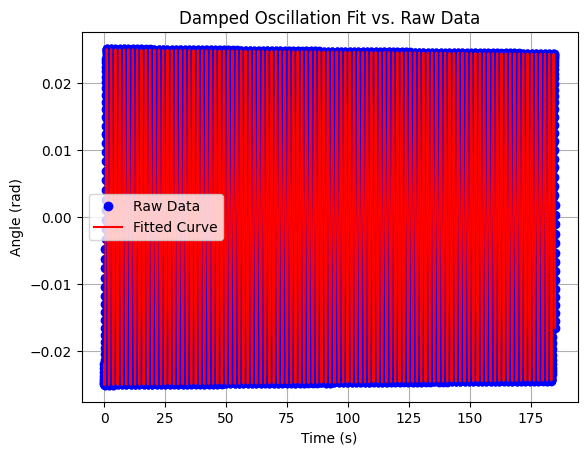

In [50]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

def fit_damped_oscillation(tt, yy):
    '''Fit a damped oscillation to the input time sequence, and return fitting parameters.'''
    tt = np.array(tt)
    yy = np.array(yy)
    
    # Estimate initial guesses using FFT (for frequency) and basic statistics
    ff = np.fft.fftfreq(len(tt), tt[1] - tt[0])   # Assume uniform time spacing
    Fyy = np.abs(np.fft.fft(yy))
    guess_freq = np.abs(ff[np.argmax(Fyy[1:]) + 1])  # Ignore the zero frequency (offset) peak
    
    # Estimate amplitude and offset
    guess_amp = (np.max(yy) - np.min(yy)) / 2
    guess_offset = np.mean(yy)
    
    # Estimate damping coefficient (use a small value for initial guess)
    guess_gamma = 0.1
    
    # Guess for omega (angular frequency)
    guess_omega = 2 * np.pi * guess_freq
    guess_phi = 0  # Initial guess for phase (can be adjusted based on data)
    
    # Initial guess vector
    guess = np.array([guess_amp, guess_gamma, guess_omega, guess_phi, guess_offset])

    # Damped oscillation function to fit
    def damped_oscillation(t, A, gamma, w, phi, c):
        return A * np.exp(-gamma * t) * np.cos(w * t + phi) + c

    # Perform curve fitting
    popt, pcov = scipy.optimize.curve_fit(damped_oscillation, tt, yy, p0=guess)

    # Extract fitted parameters
    A, gamma, w, phi, c = popt
    
    # Calculate frequency and period
    f = w / (2 * np.pi)
    period = 1 / f
    
    # Return the fit parameters and the fitted function
    fitfunc = lambda t: A * np.exp(-gamma * t) * np.cos(w * t + phi) + c
    return {
        "amp": A, 
        "gamma": gamma, 
        "omega": w, 
        "phase": phi, 
        "offset": c, 
        "freq": f, 
        "period": period, 
        "fitfunc": fitfunc,
        "maxcov": np.max(pcov), 
        "rawres": (guess, popt, pcov)
    }

# Example data (replace with your real pendulum data)
# Fit the damped oscillation
fit_results = fit_damped_oscillation(time, theta_normalized)

# Extract fitted parameters
A_fit = fit_results['amp']
gamma_fit = fit_results['gamma']
omega_fit = fit_results['omega']
phi_fit = fit_results['phase']
offset_fit = fit_results['offset']
period_fit = fit_results['period']

# Print the results
print(f"Fitted parameters: A = {A_fit:.3f}, γ = {gamma_fit:.3f}, ω = {omega_fit:.3f}, φ = {phi_fit:.3f}, Offset = {offset_fit:.3f}")
print(f"Estimated Period: {period_fit:.3f} s")

# Plot the raw data and the fitted damped curve
plt.plot(time, theta_normalized, 'bo', label="Raw Data")  # Blue dots for raw data
plt.plot(time, fit_results["fitfunc"](time), 'r-', label="Fitted Curve")  # Red line for fit
plt.xlabel("Time (s)")
plt.ylabel("Angle (rad)")
plt.title("Damped Oscillation Fit vs. Raw Data")
plt.legend()
plt.grid(True)
plt.show()


In [51]:
g = omega_fit**2 * L
print(g)

9.693436806720886
